# Variational encoder model

## import lib


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import gpytorch

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm


## ML pipeline

### Step 0. Model Hyperparameters

In [108]:
# model hyperparameters
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 30
x_dim = 19
hidden_dim = 256
output_dim = 19

lr = 5e-5
epochs = 125

training_seed = 21


### Step 1. Load Dataset

get data from file

In [109]:
num_seeds = 30
seed = 0
# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds): # HEBB-FULL_STATE-seed_0-fullstate-rand-0
    data_fullstate[i] = np.load(f"data/HEBB-full/HEBB-FULL_STATE-seed_{seed}-fullstate-rand-{i}.npz")    
    # data_no_joint_pos[i] = np.load(f"data/performance/HEBB-FULL-STATE_seed-{seed}-no_joint_pos-rand-{i}.npz")
    # data_no_joint_vel[i] = np.load(f"data/performance/HEBB-FULL-STATE_seed-{seed}-no_joint_vel-rand-{i}.npz")
    # data_no_action[i] = np.load(f"data/performance/HEBB-FULL-STATE_seed-{seed}-no_action-rand-{i}.npz")
    # data_no_imu[i] = np.load(f"data/performance/HEBB-FULL-STATE_seed-{seed}-no_imu-rand-{i}.npz")
    # data_no_fc[i] = np.load(f"data/performance/HEBB-FULL-STATE_seed-{seed}-no_fc-rand-{i}.npz")

In [110]:
all_state_dim = 64
state_dim = 64
action_dim = 19

train_x = torch.empty((0, all_state_dim), dtype=torch.float32 ,device=DEVICE)
train_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
test_x = torch.empty((0, all_state_dim), dtype=torch.float32,device=DEVICE)
test_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
for i in range(training_seed):
    train_x = torch.cat((train_x, torch.tensor(data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    train_y = torch.cat((train_y, torch.tensor(data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
for j in range(training_seed, num_seeds):
    test_x = torch.cat((test_x, torch.tensor(data_fullstate[j]["state"].reshape(data_fullstate[j]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    test_y = torch.cat((test_y, torch.tensor(data_fullstate[j]["action_lowpass"].reshape(data_fullstate[j]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)

Converge to TensorDataset

In [111]:
state_index = torch.arange(0, 19)
state_dim = len(state_index)

train_dataset = TensorDataset(train_x[:,state_index], train_y)
test_dataset = TensorDataset(test_x[:,state_index], test_y)

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TRAIN : X , Y shape :  torch.Size([10500, 19]) torch.Size([10500, 19])
TEST : X , Y shape :  torch.Size([4500, 19]) torch.Size([4500, 19])


Explore some data

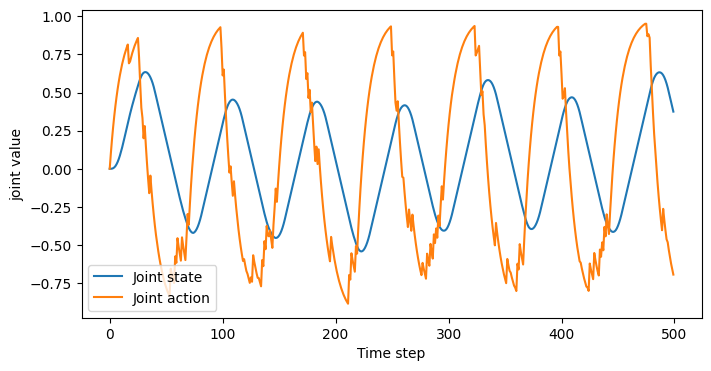

In [112]:
plt.figure(figsize=(8, 4))
plt.plot(train_x[:, state_index].cpu().numpy()[10000:11000, 6], label='Joint state')
plt.plot(train_y.cpu().numpy()[10000:11000, 6], label='Joint action')
plt.xlabel('Time step')
plt.ylabel('joint value')
plt.legend()

### Step 2. Define Model

In [87]:
"""
    A simple implementation of Gaussian MLP Encoder
"""
class Predictor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.FC_mean  = nn.Linear(hidden_dim, output_dim)
        self.FC_var   = nn.Linear (hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        self.LeakyReLU = nn.ReLU()
        self.softplus = nn.Softplus()
        
        self.training = True
        
    def reparameterization(self , mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
    
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        mean     = self.FC_mean(h_)         # encoder produces mean and log of variance 
        log_var  = self.FC_var(h_)          # (i.e., parateters of simple tractable normal distribution "q"
        
        # log_var  = self.softplus(log_var)  # clamp log_var to avoid numerical issues
        
        z = self.reparameterization(mean, torch.exp(log_var))  # reparameterization trick
        # z is sampling from the distribution z = mean + var * epsilon
        
        return z,mean, log_var

In [88]:
print(state_dim)

19


In [89]:
model = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
# model = NN(input_dim=state_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(DEVICE)

### Step 3. Define Loss function
- using MSE loss

$$
\mathcal{L}(z,\hat{z}) = \| z^2 - \hat{z}^2 \|^2
$$

In [113]:
MSEloss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = MSEloss(x_hat, x)  # Using MSE loss instead of binary cross entropy
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


### Step 4. Training network

In [114]:
# ----- Training Loop -----
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)    # dim = [batch_size, state_dim]
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        pred, mean , log_var = model(x_batch)
        loss = MSEloss(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(train_dataset)
    train_losses.append(avg_loss)

    # ----- Evaluate -----
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred, mean , log_var = model(x_batch)
            total_test_loss += MSEloss(pred, y_batch).item() * x_batch.size(0)

    avg_test_loss = total_test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch 1/125 | Train Loss: 0.013553 | Test Loss: 0.017559
Epoch 2/125 | Train Loss: 0.013531 | Test Loss: 0.017442
Epoch 3/125 | Train Loss: 0.013533 | Test Loss: 0.017441
Epoch 4/125 | Train Loss: 0.013546 | Test Loss: 0.017566
Epoch 5/125 | Train Loss: 0.013518 | Test Loss: 0.017698
Epoch 6/125 | Train Loss: 0.013530 | Test Loss: 0.017570
Epoch 7/125 | Train Loss: 0.013528 | Test Loss: 0.017502
Epoch 8/125 | Train Loss: 0.013522 | Test Loss: 0.017493
Epoch 9/125 | Train Loss: 0.013519 | Test Loss: 0.017501
Epoch 10/125 | Train Loss: 0.013516 | Test Loss: 0.017548
Epoch 11/125 | Train Loss: 0.013510 | Test Loss: 0.017512
Epoch 12/125 | Train Loss: 0.013529 | Test Loss: 0.017498
Epoch 13/125 | Train Loss: 0.013508 | Test Loss: 0.017537
Epoch 14/125 | Train Loss: 0.013507 | Test Loss: 0.017490
Epoch 15/125 | Train Loss: 0.013508 | Test Loss: 0.017460
Epoch 16/125 | Train Loss: 0.013515 | Test Loss: 0.017603
Epoch 17/125 | Train Loss: 0.013515 | Test Loss: 0.017512
Epoch 18/125 | Train Lo

Text(0, 0.5, 'Loss')

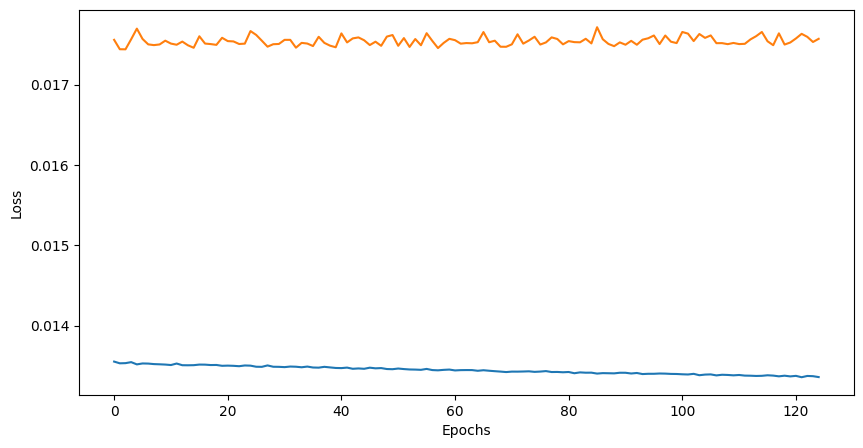

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [117]:
# ----- Evaluate -----
model.eval()
total_test_loss = 0.0
preds_list, targets_list = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        pred, mean , log_var = model(x_batch)
        total_test_loss += MSEloss(pred, y_batch).item() * x_batch.size(0)

        preds_list.append(pred.cpu().numpy())
        targets_list.append(y_batch.cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataset)

# Convert all predictions and targets
preds_all = np.vstack(preds_list)
targets_all = np.vstack(targets_list)

# ---- Metrics ----
mse = np.mean((preds_all - targets_all)**2, axis=0)           # per output
rmse = np.sqrt(mse)
mae = np.mean(np.abs(preds_all - targets_all), axis=0)
ss_res = np.sum((targets_all - preds_all) ** 2, axis=0)
ss_tot = np.sum((targets_all - np.mean(targets_all, axis=0)) ** 2, axis=0)
r2 = 1 - ss_res / ss_tot

print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss (MSE): {avg_test_loss:.6f}")
print(f"  MAE per output:  {mae}")
print(f"  RMSE per output: {rmse}")
print(f"  R2 per output:   {r2}")

Epoch 125/125 | Train Loss: 0.013360 | Test Loss (MSE): 0.017571
  MAE per output:  [0.06600133 0.06796389 0.08014289 0.09056044 0.10344116 0.09046247
 0.09194599 0.09784322 0.10031669 0.06909637 0.06565395 0.10224561
 0.08447027 0.09247622 0.10434853 0.10658228 0.14247942 0.0968051
 0.0824267 ]
  RMSE per output: [0.12216025 0.11574239 0.14282688 0.1261215  0.14638326 0.1346214
 0.12576558 0.13237612 0.13464856 0.08900905 0.08979121 0.13273177
 0.12505941 0.13711292 0.14718065 0.157058   0.1859672  0.12117406
 0.12070915]
  R2 per output:   [0.97149897 0.9742813  0.96042365 0.93974274 0.94558895 0.952469
 0.95717305 0.9137316  0.94242805 0.92990017 0.9459707  0.9470256
 0.9654454  0.9595711  0.94504094 0.93290794 0.8886806  0.81356585
 0.9687674 ]


### Step 4.2 add KL loss

In [66]:
lr = 5e-4
model2 = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer2 = Adam(model.parameters(), lr=lr)


In [67]:
# ----- Training Loop -----
train_losses = []
test_losses = []

for epoch in range(epochs):
    model2.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)    # dim = [batch_size, state_dim]
        y_batch = y_batch.to(DEVICE)

        optimizer2.zero_grad()
        pred, mean , log_var = model2(x_batch)
        loss = loss_function(pred, y_batch , mean , log_var)
        loss.backward()
        optimizer2.step()

        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(train_dataset)
    train_losses.append(avg_loss)

    # ----- Evaluate -----
    model2.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred, mean , log_var = model2(x_batch)
            total_test_loss += loss_function(pred, y_batch , mean , log_var).item() * x_batch.size(0)

    avg_test_loss = total_test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch 1/125 | Train Loss: 6.211175 | Test Loss: 6.201867
Epoch 2/125 | Train Loss: 6.196297 | Test Loss: 6.208408
Epoch 3/125 | Train Loss: 6.203120 | Test Loss: 6.196687
Epoch 4/125 | Train Loss: 6.198278 | Test Loss: 6.213844
Epoch 5/125 | Train Loss: 6.196608 | Test Loss: 6.206394
Epoch 6/125 | Train Loss: 6.201470 | Test Loss: 6.198438
Epoch 7/125 | Train Loss: 6.200234 | Test Loss: 6.198863
Epoch 8/125 | Train Loss: 6.195505 | Test Loss: 6.200811
Epoch 9/125 | Train Loss: 6.200905 | Test Loss: 6.190713
Epoch 10/125 | Train Loss: 6.200429 | Test Loss: 6.195384
Epoch 11/125 | Train Loss: 6.203999 | Test Loss: 6.199339
Epoch 12/125 | Train Loss: 6.196524 | Test Loss: 6.213915
Epoch 13/125 | Train Loss: 6.198264 | Test Loss: 6.212572
Epoch 14/125 | Train Loss: 6.200926 | Test Loss: 6.204231
Epoch 15/125 | Train Loss: 6.197096 | Test Loss: 6.188240
Epoch 16/125 | Train Loss: 6.209237 | Test Loss: 6.205911
Epoch 17/125 | Train Loss: 6.206238 | Test Loss: 6.201285
Epoch 18/125 | Train Lo

# Evaluate

In [127]:
# eva_input = train_x[:500 , :19]
# eva_label = train_y[:500 , :]

eva_input = test_x[2500:3500 , :19]
eva_label = test_y[2500:3500 , :]

dim  = 19
cols = 3
rows = math.ceil(dim / cols)

# ตั้งค่าสถานะว่า eva_sigma เป็น std หรือ var
ASSUME_SIGMA_IS_STD = False  # ถ้า eva_sigma คือ std ให้ True, ถ้าเป็น variance อยู่แล้ว ให้ False

### MSE loss


In [128]:

eva_pred , eva_mean , eva_log_var = model(eva_input)
# เตรียมแกน x (จะพล็อตตามลำดับ index ของ sample)
T = eva_mean.shape[0]
x = np.arange(T)

# แปลงเป็น numpy
y_np = eva_label.detach().cpu().numpy()
pred_np = eva_pred.detach().cpu().numpy()
mu_np  = eva_mean.detach().cpu().numpy()                   # [T, 19]
sig_np = torch.exp(eva_log_var).detach().cpu().numpy()                  # [T, 19]
var_np = (sig_np**2) if ASSUME_SIGMA_IS_STD else sig_np    # [T, 19]
# var_np = np.clip(var_np, 1e-12, None)                      # กันติดลบ/ศูนย์

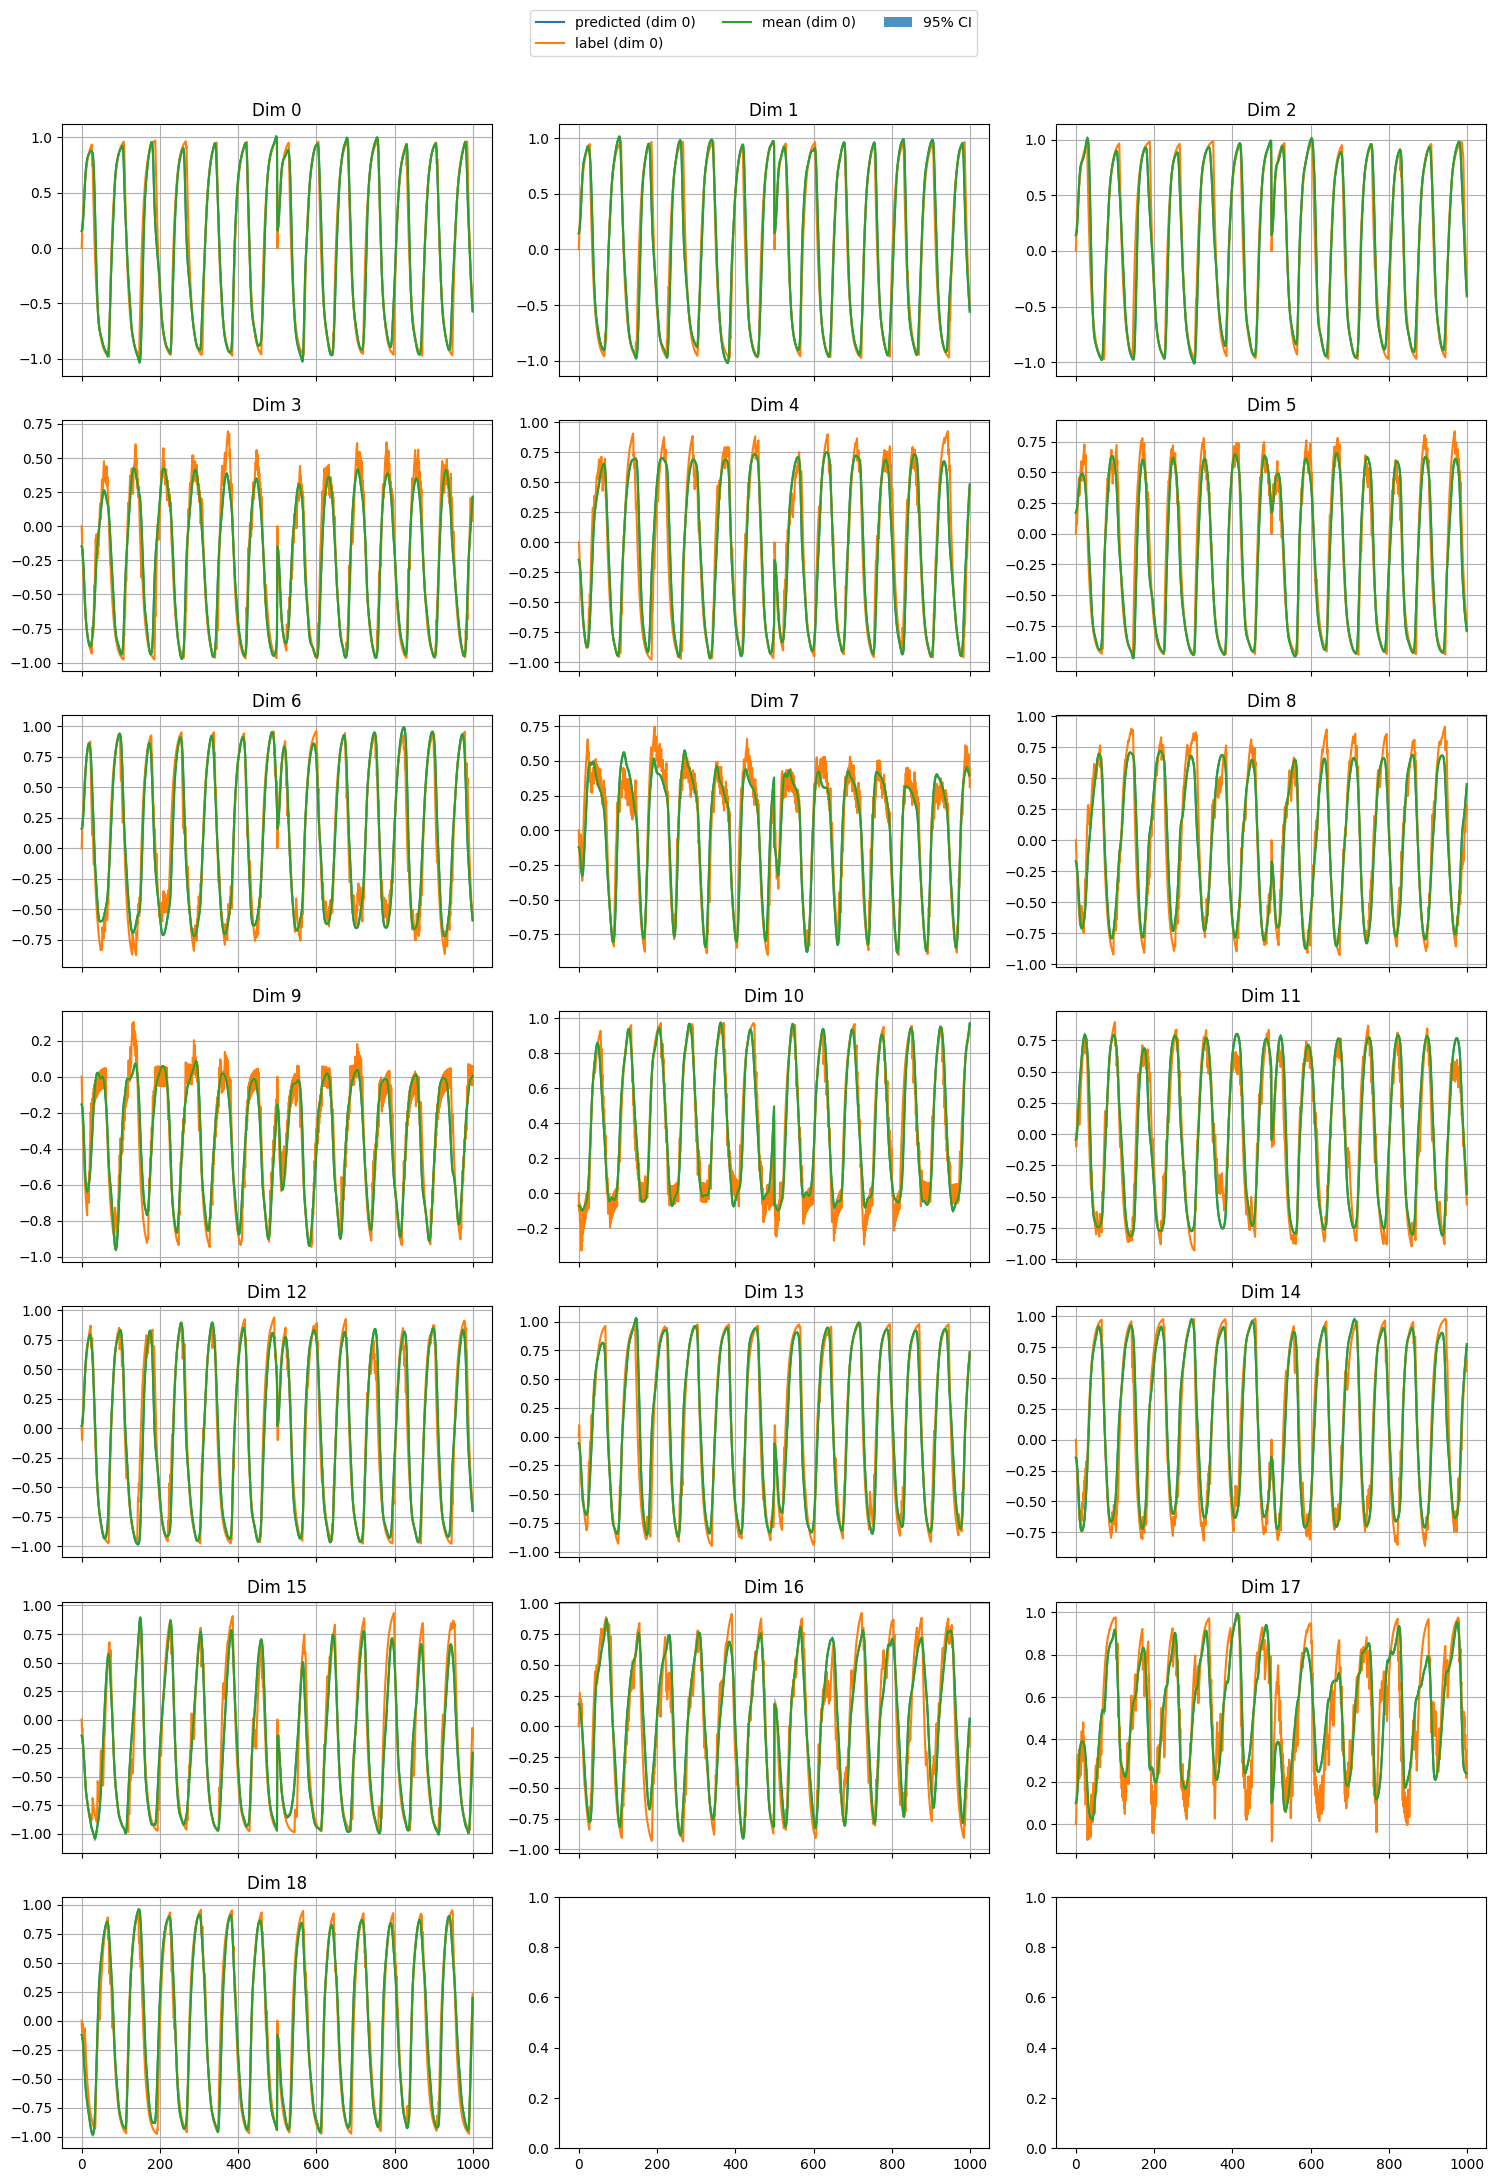

In [129]:
# เริ่มวาด 19 subplot, 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
axes = axes.flatten()

for d in range(dim):
    ax = axes[d]
    mu   = mu_np[:, d]
    var  = var_np[:, d]
    pred = pred_np[:, d]
    std  = np.sqrt(var)
    lo   = mu - 1.96 * std
    up   = mu + 1.96 * std
    y    = y_np[:, d]

    # เส้น mean
    ax.plot(x, pred, label=f"predicted (dim {d})")
    ax.plot(x, y, label=f"label (dim {d})")
    ax.plot(x, mu, label=f"mean (dim {d})")
    # แถบ 95% CI
    ax.fill_between(x, lo, up, alpha=0.8, label="95% CI")

    ax.set_title(f"Dim {d}")
    ax.grid(True)

fig.tight_layout()
# ดึง legend จากซับพล็อตแรกเพื่อลดความรก
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
plt.show()

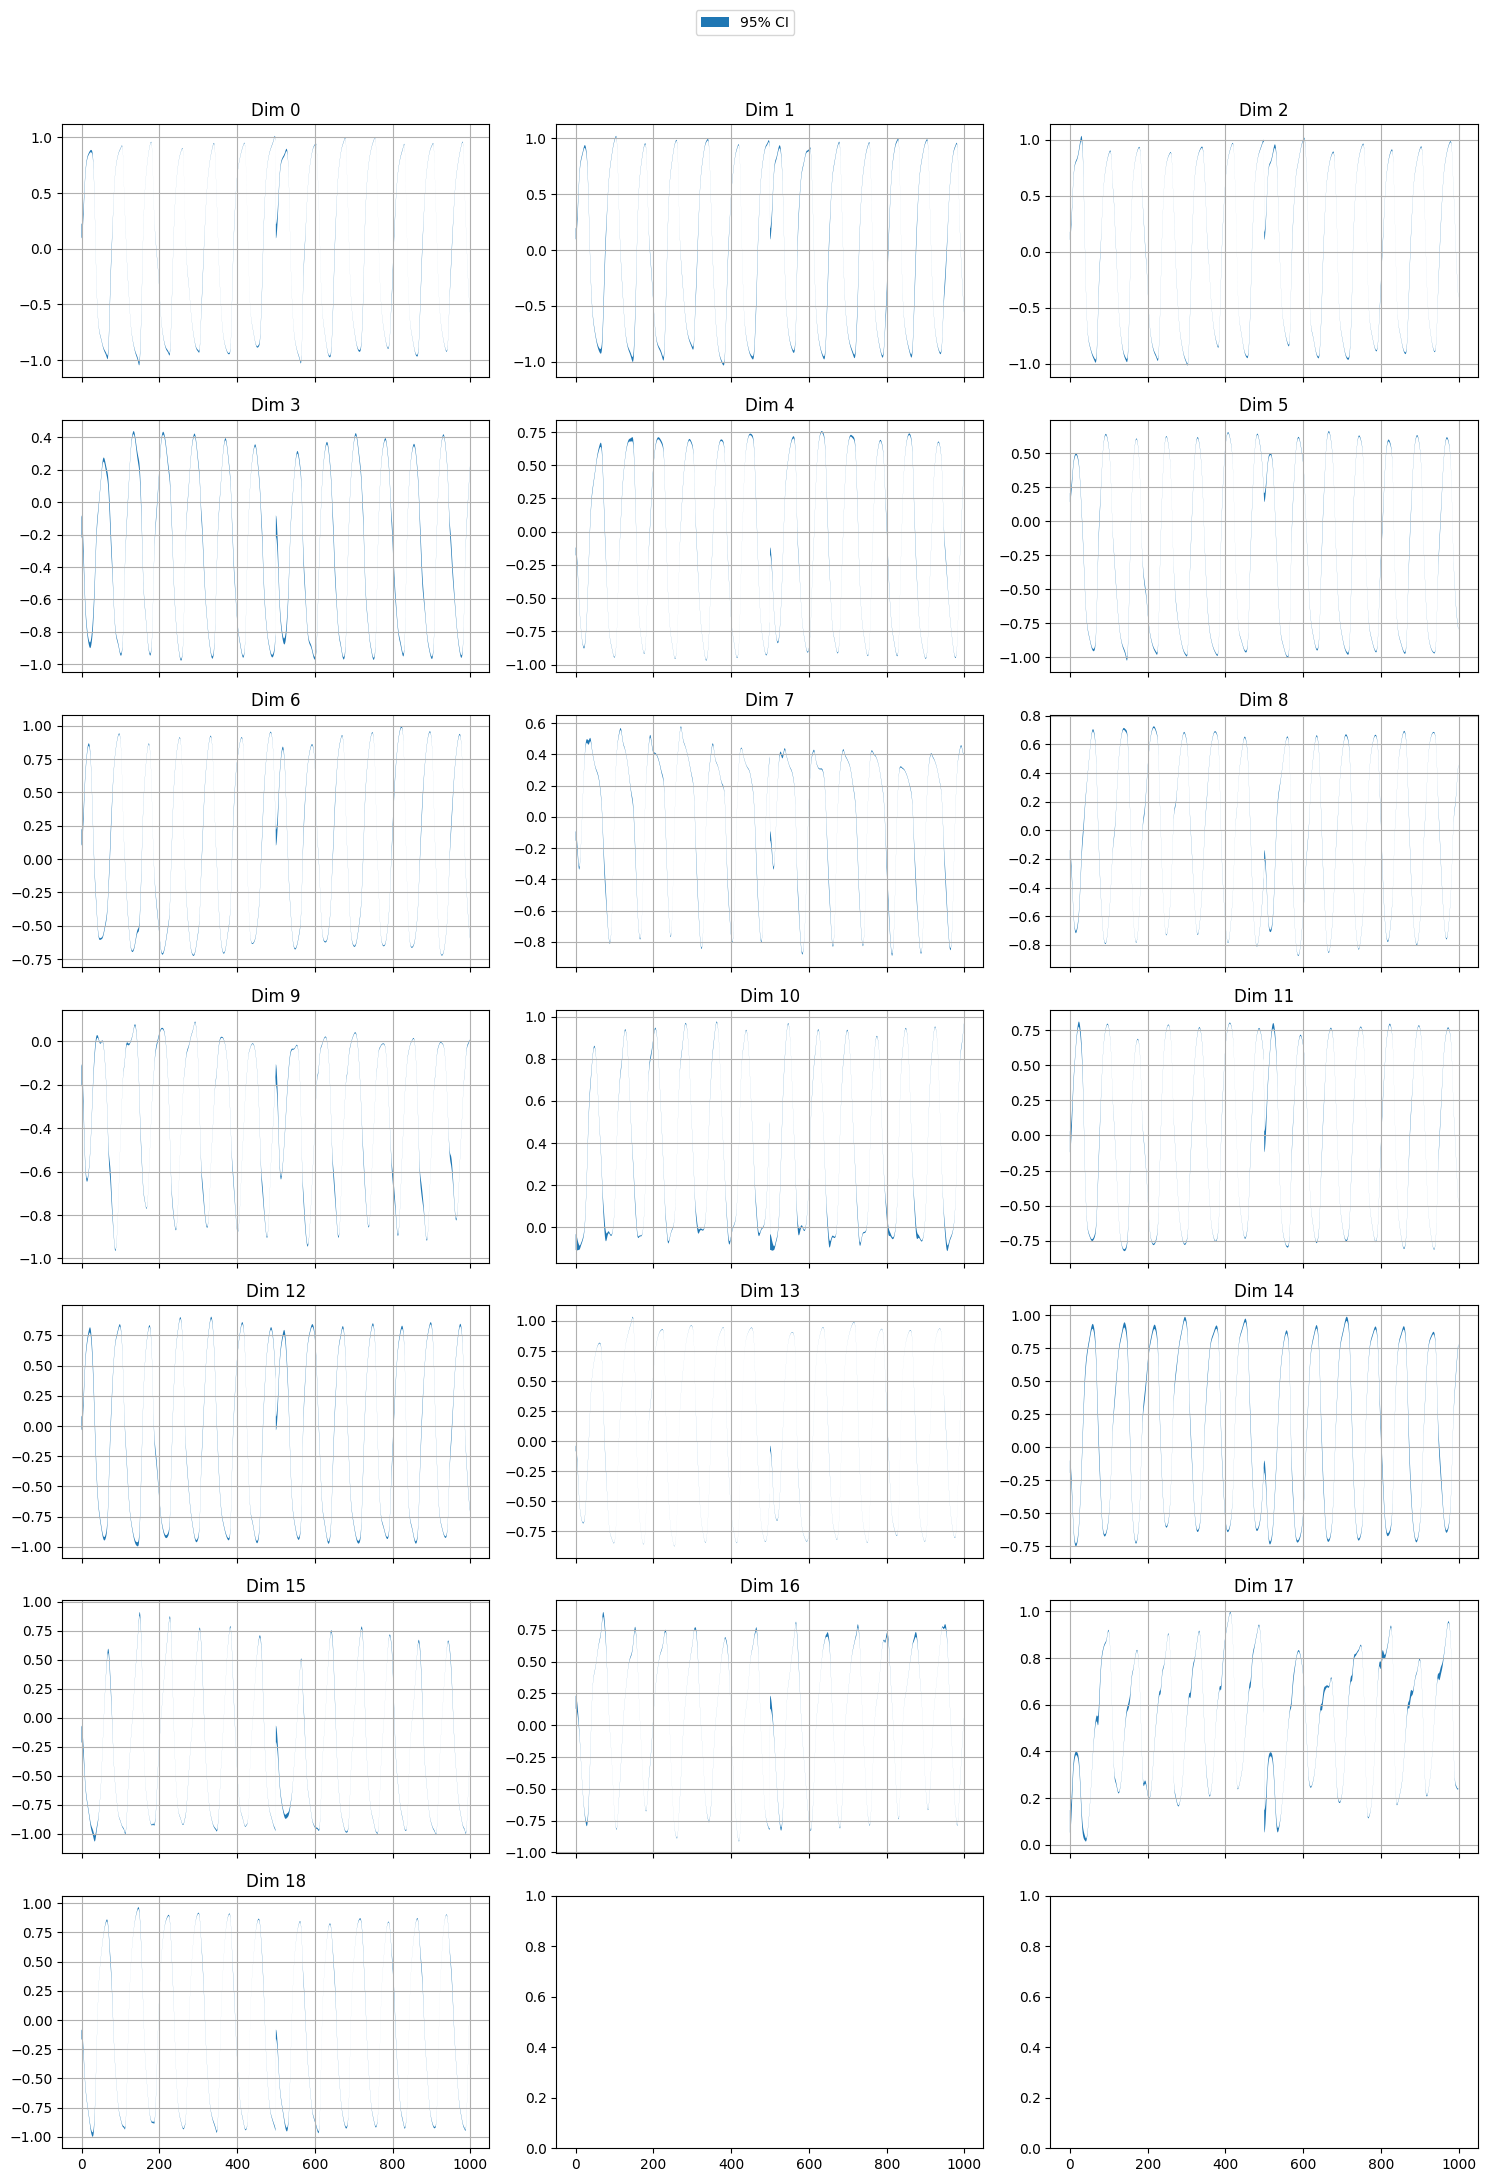

In [130]:
# เริ่มวาด 19 subplot, 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
axes = axes.flatten()

for d in range(dim):
    ax = axes[d]
    mu   = mu_np[:, d]
    var  = var_np[:, d]
    pred = pred_np[:, d]
    std  = np.sqrt(var)
    lo   = mu - 1.96 * std
    up   = mu + 1.96 * std
    y    = y_np[:, d]

    # เส้น mean
    # แถบ 95% CI
    ax.fill_between(x, lo, up, alpha=1.0, label="95% CI")

    ax.set_title(f"Dim {d}")
    ax.grid(True)

fig.tight_layout()
# ดึง legend จากซับพล็อตแรกเพื่อลดความรก
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
plt.show()

### MSE + KL loss

In [84]:

eva_pred , eva_mean , eva_log_var = model2(eva_input)
# เตรียมแกน x (จะพล็อตตามลำดับ index ของ sample)
T = eva_mean.shape[0]
x = np.arange(T)

# แปลงเป็น numpy
y_np = eva_label.detach().cpu().numpy()
pred_np = eva_pred.detach().cpu().numpy()
mu_np  = eva_mean.detach().cpu().numpy()                   # [T, 19]
sig_np = torch.exp(eva_log_var).detach().cpu().numpy()                  # [T, 19]
var_np = (sig_np**2) if ASSUME_SIGMA_IS_STD else sig_np    # [T, 19]
# var_np = np.clip(var_np, 1e-12, None)                      # กันติดลบ/ศูนย์

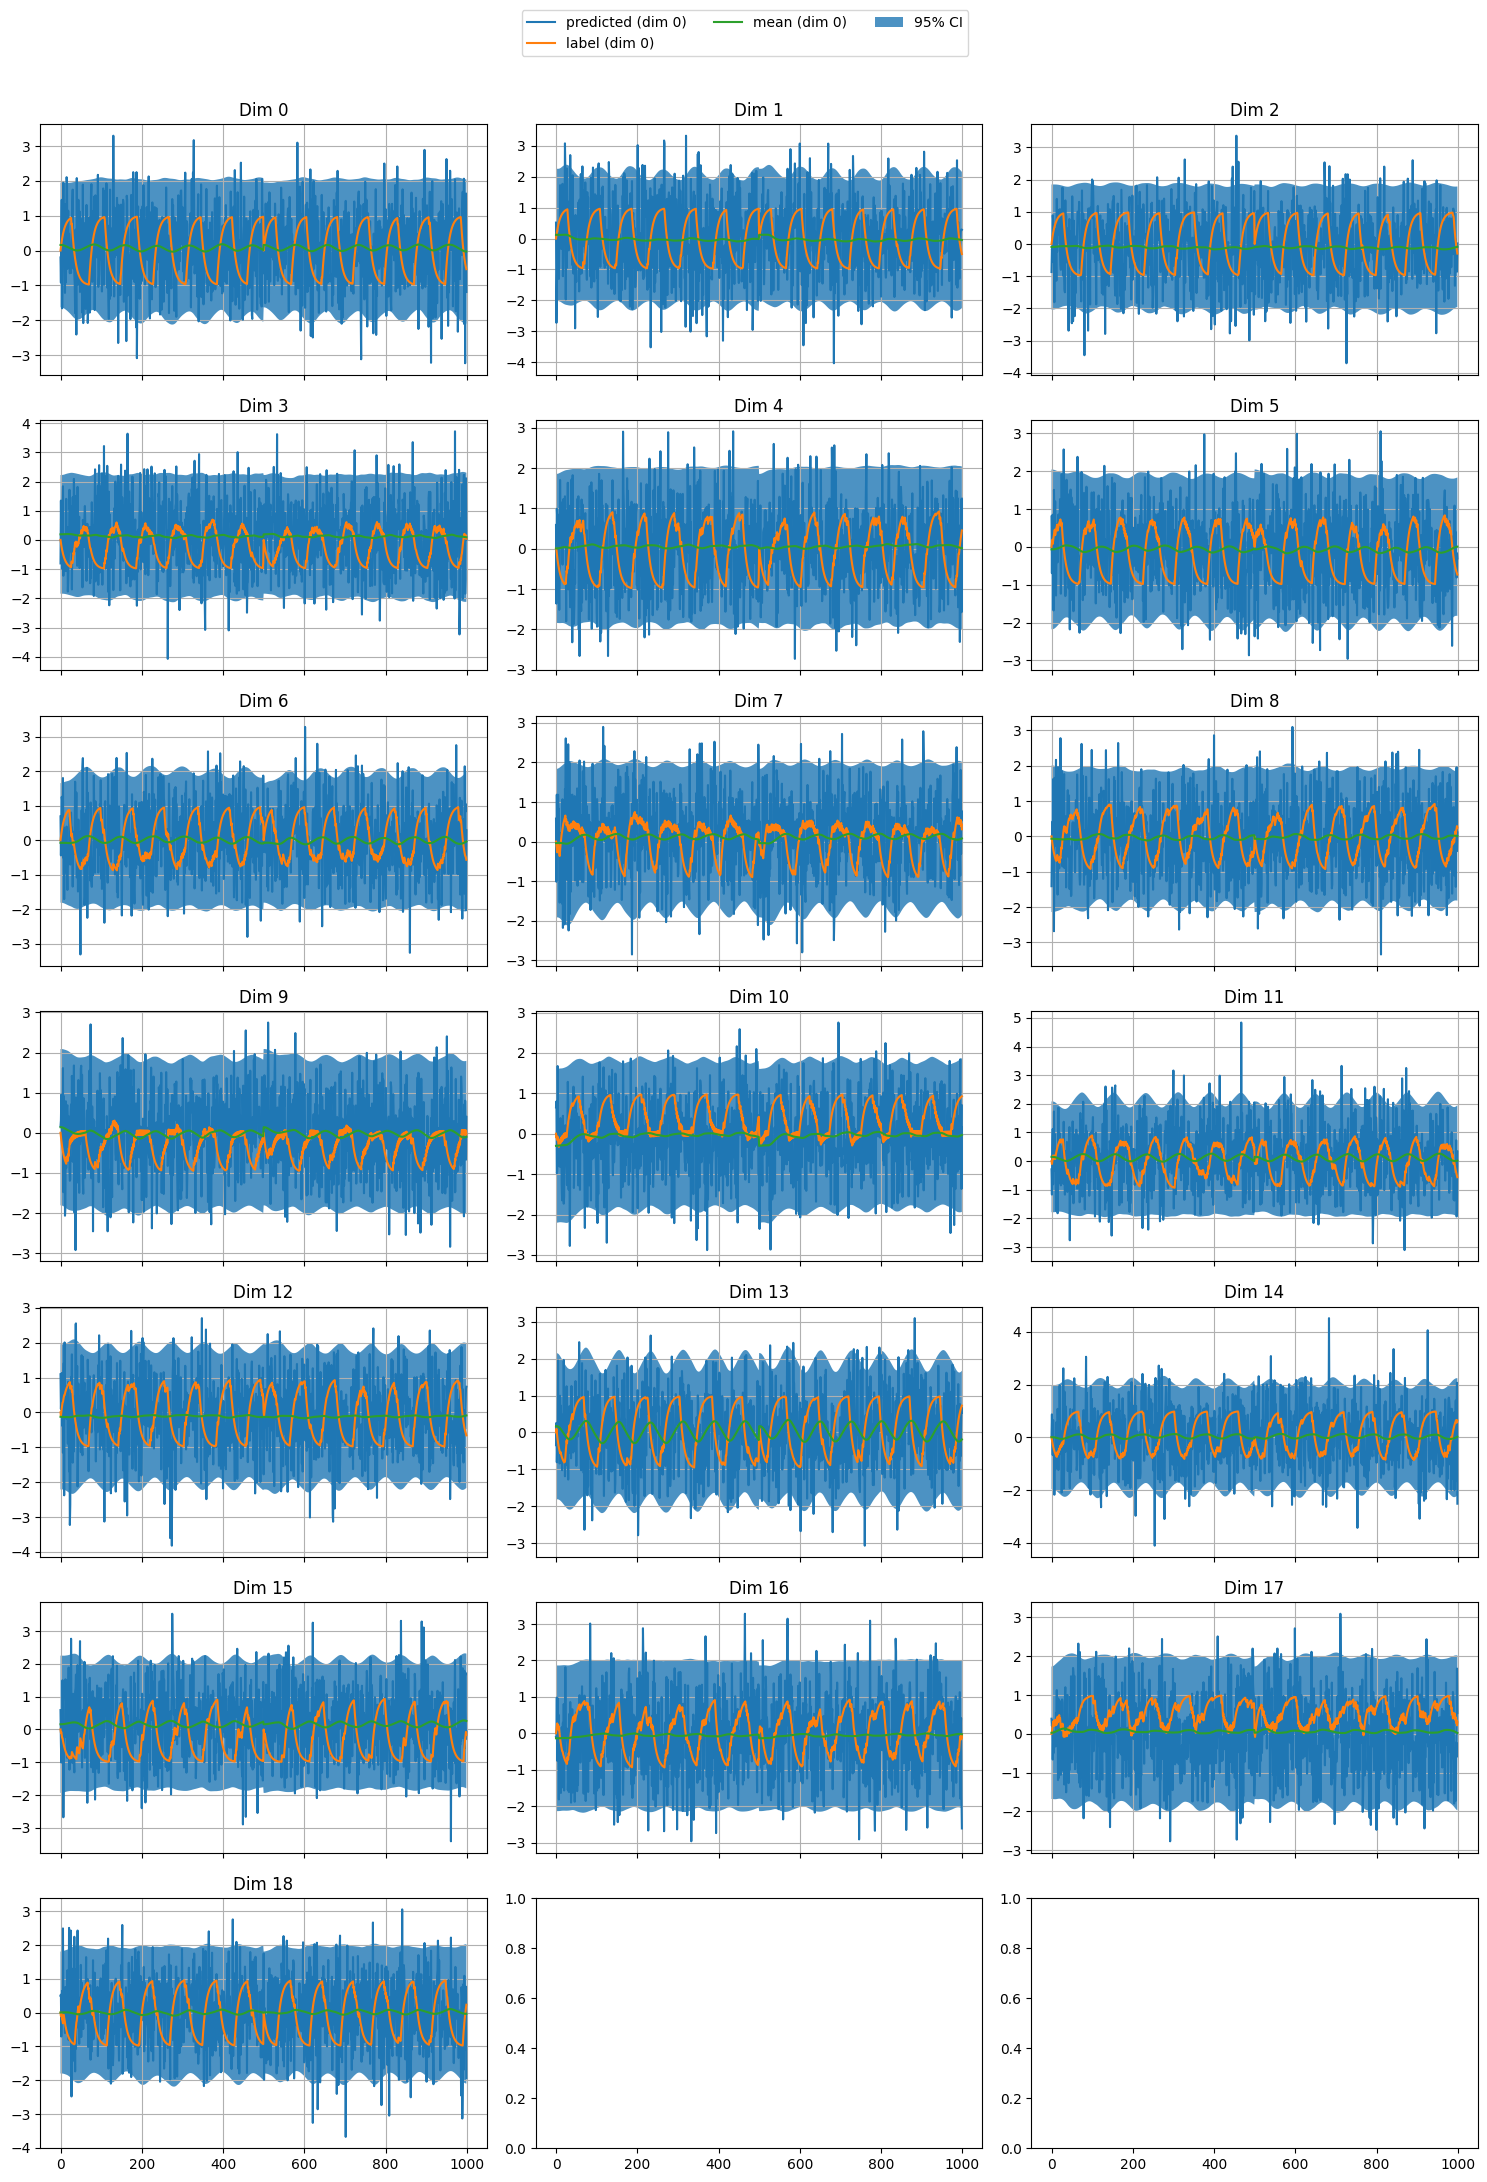

In [85]:
# เริ่มวาด 19 subplot, 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
axes = axes.flatten()

for d in range(dim):
    ax = axes[d]
    mu   = mu_np[:, d]
    var  = var_np[:, d]
    pred = pred_np[:, d]
    std  = np.sqrt(var)
    lo   = mu - 1.96 * std
    up   = mu + 1.96 * std
    y    = y_np[:, d]

    # เส้น mean
    ax.plot(x, pred, label=f"predicted (dim {d})")
    ax.plot(x, y, label=f"label (dim {d})")
    ax.plot(x, mu, label=f"mean (dim {d})")
    # แถบ 95% CI
    ax.fill_between(x, lo, up, alpha=0.8, label="95% CI")

    ax.set_title(f"Dim {d}")
    ax.grid(True)

fig.tight_layout()
# ดึง legend จากซับพล็อตแรกเพื่อลดความรก
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
plt.show()

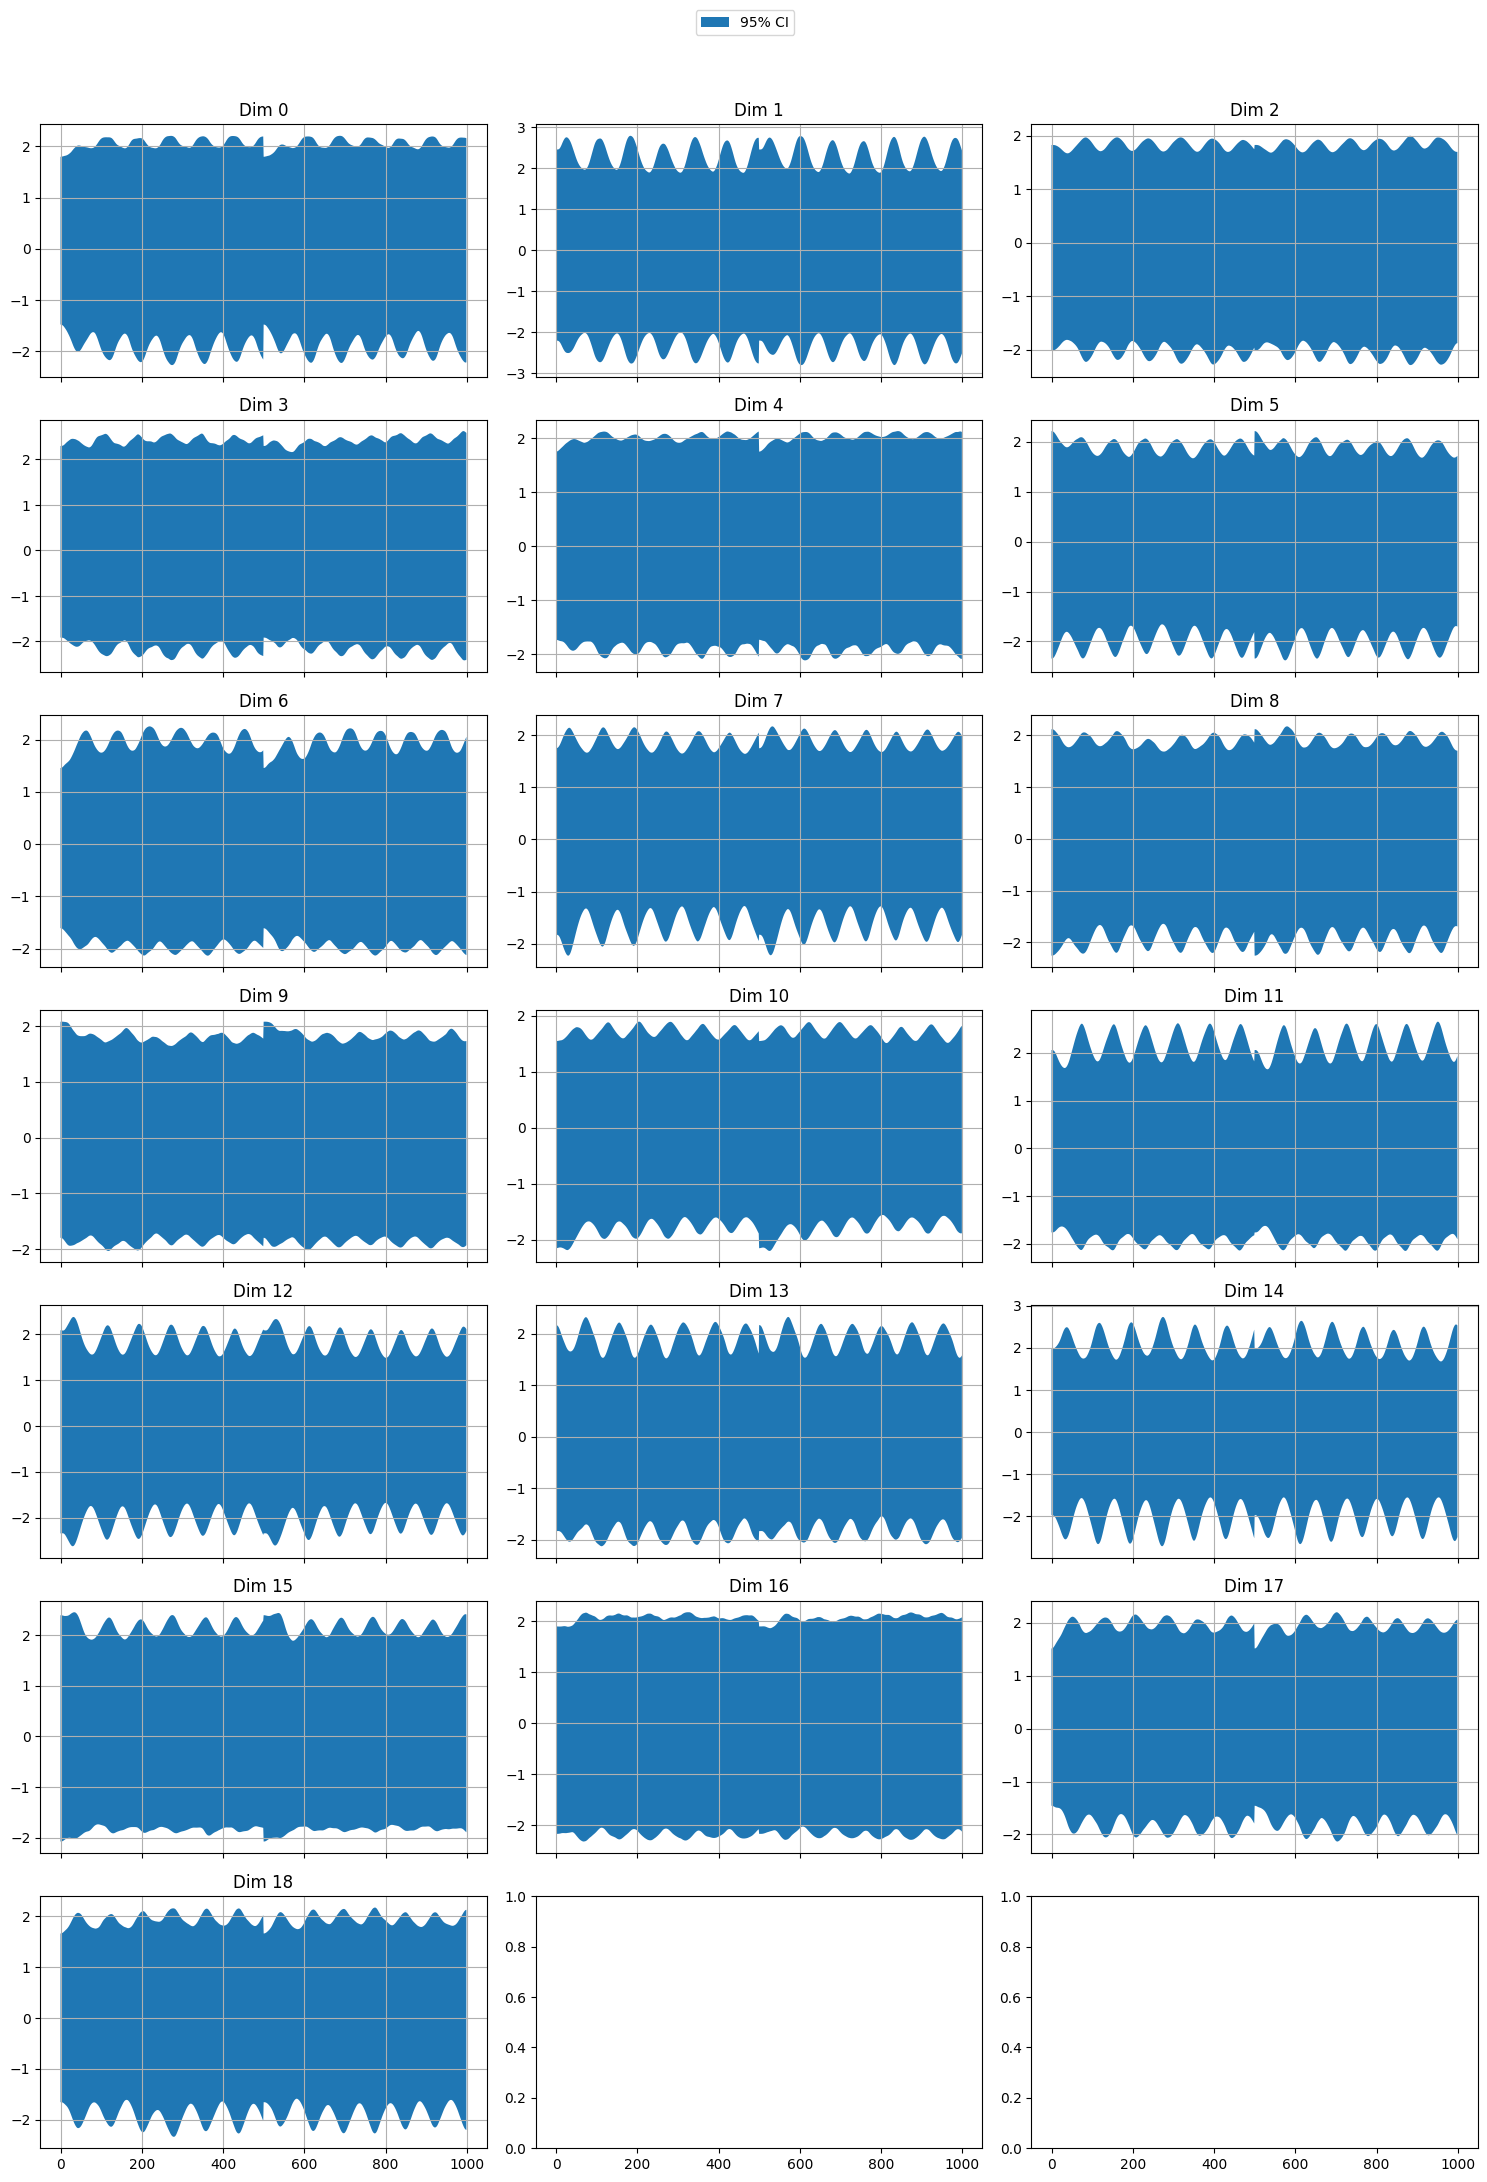

In [72]:
# เริ่มวาด 19 subplot, 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
axes = axes.flatten()

for d in range(dim):
    ax = axes[d]
    mu   = mu_np[:, d]
    var  = var_np[:, d]
    pred = pred_np[:, d]
    std  = np.sqrt(var)
    lo   = mu - 1.96 * std
    up   = mu + 1.96 * std
    y    = y_np[:, d]

    # เส้น mean
    # แถบ 95% CI
    ax.fill_between(x, lo, up, alpha=1.0, label="95% CI")

    ax.set_title(f"Dim {d}")
    ax.grid(True)

fig.tight_layout()
# ดึง legend จากซับพล็อตแรกเพื่อลดความรก
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
plt.show()